In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
save_images = False
sep = ","
enc = "utf-8"
file = "cc_vs_fh04.csv"
df = pd.read_csv(file, sep=sep, header=0, encoding=enc)

In [3]:
def plot_alg_box(df, feat="OOA", suffixes=["FH04", "CC"], ylabel=None,
        print_latex=False, ylim=None, figsize=(12,8), yticks=None):
    col_names = []
    title = feat
    for i in range(len(suffixes)):
        suffix = suffixes[i]
        col_name = feat + "_" + suffix
        col_names.append(col_name)
    sub_df = df.loc[:, col_names]
    
    if print_latex:
        df_desc = sub_df.describe(include="all")
        df_desc = df_desc.loc[["mean", "std", "25%", "50%", "75%"]]
        latex_str = df_desc.to_latex(escape=False, float_format="%.2f")
        latex_str = latex_str.replace("_", "\_")
        latex_str = latex_str.replace("%", "\%")
        latex_str = latex_str.replace("|S|", "$|\mathcal{S}|$")
        
        print(latex_str)
    
    sub_df.plot(kind="box", figsize=figsize, rot=90, title=title, grid=True,
        showmeans=True, ylabel=ylabel, ylim=ylim, yticks=yticks)

\begin{tabular}{lrrr}
\toprule
{} &  OOA\_FH04 &  OOA\_CC &  OOA\_CP \\
\midrule
mean &      0.77 &    0.51 &    0.86 \\
std  &      0.08 &    0.18 &    0.06 \\
25\%  &      0.72 &    0.38 &    0.82 \\
50\%  &      0.77 &    0.52 &    0.86 \\
75\%  &      0.82 &    0.64 &    0.90 \\
\bottomrule
\end{tabular}



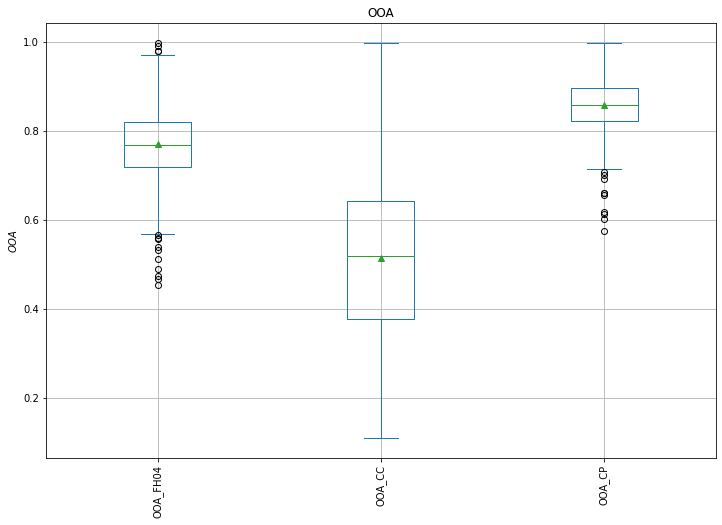

In [4]:
plot_alg_box(df=df, feat="OOA", ylabel=r"$OOA$", print_latex=True, suffixes=["FH04", "CC", "CP"])
if save_images:
    plt.savefig("cc_vs_fh04_ooa.png", bbox_inches="tight")

\begin{tabular}{lrrr}
\toprule
{} &  $|\mathcal{S}|$\_FH04 &  $|\mathcal{S}|$\_CC &  $|\mathcal{S}|$\_CP \\
\midrule
mean &    159.72 &  100.90 &  558.13 \\
std  &     97.92 &   79.89 &  317.23 \\
25\%  &     88.25 &   45.25 &  326.25 \\
50\%  &    139.00 &   83.00 &  496.50 \\
75\%  &    205.75 &  135.00 &  717.75 \\
\bottomrule
\end{tabular}



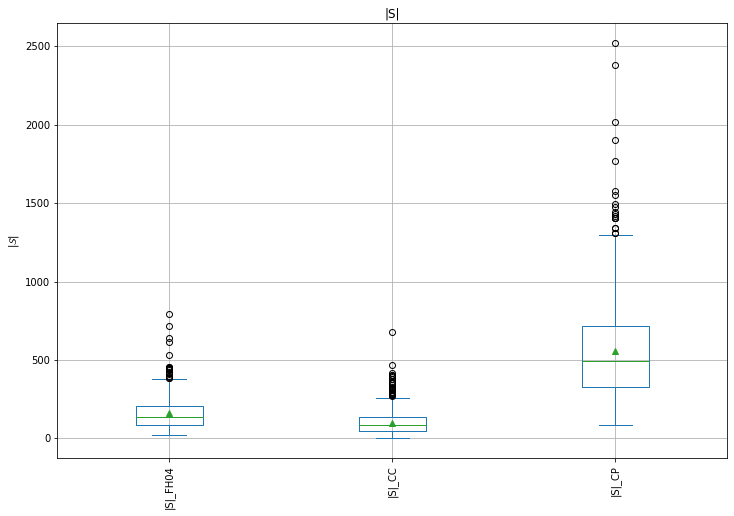

In [5]:
plot_alg_box(df=df, feat="|S|", ylabel=r"$|\mathcal{S}|$", print_latex=True, suffixes=["FH04", "CC", "CP"])
if save_images:
    plt.savefig("cc_vs_fh04_sizes.png", bbox_inches="tight")

In [6]:
def outliers_idxs(arr):    
    q025 = np.quantile(a=arr, q=0.25, axis=0)
    q075 = np.quantile(a=arr, q=0.75, axis=0)
    iqr = q075 - q025
    lb = q025 - 1.5 * iqr
    ub = q075 + 1.5 * iqr
    mask = (arr >= ub) | (arr <= lb)
    out_rows = np.where(mask == True)[0]
    return out_rows


def ut_test(df, alpha=0.05, feat="OOA", suffixes=["FH04", "CC"]):
    col_names = []
    title = feat
    print(title)
    if len(suffixes) != 2:
        raise Exception("Cannot apply u- or t-Test")
    for i in range(len(suffixes)):
        suffix = suffixes[i]
        col_name = feat + "_" + suffix
        col_names.append(col_name)
    sub_df = df.loc[:, col_names]
    
    idxs_0 = outliers_idxs(arr=sub_df[col_names[0]].to_numpy())
    idxs_1 = outliers_idxs(arr=sub_df[col_names[1]].to_numpy())
    out_idxs = np.vstack((idxs_0[:, None], idxs_1[:, None]))
    out_idxs = np.unique(out_idxs)
    print("Remove {0} outliers".format(out_idxs.shape[0]))
    remaining_idxs = np.arange(df.shape[0], dtype=np.uint32)
    remaining_idxs = np.delete(remaining_idxs, out_idxs)
    sub_df = sub_df.iloc[remaining_idxs, :]
    
    is_normal = True
    for i in range(len(col_names)):
        col_name = col_names[i]
        _, p_val = st.shapiro(sub_df[col_name])
        is_col_normal = p_val < alpha
        print("{0} is normal: {1} (p={2})".format(col_name, is_col_normal, p_val))
        is_normal = is_normal and is_col_normal
    _, p_val = st.bartlett(sub_df[col_names[0]], sub_df[col_names[1]])
    equal_var = p_val < alpha
    print("Equal variance: {0} (p={1})".format(equal_var, p_val))
    if is_normal and equal_var:
        _, p_val = st.ttest_ind(a=sub_df[col_names[0]], b=sub_df[col_names[1]])
        significant = p_val < alpha
        print("T-Test for {0} is significant: {1} (p={2:.5f})".format(title, significant, p_val))
    else:
        _, p_val = st.mannwhitneyu(x=sub_df[col_names[0]], y=sub_df[col_names[1]])
        significant = p_val < alpha
        print("U-Test for {0} is significant: {1} (p={2:.5f})".format(title, significant, p_val))

In [7]:
ut_test(df=df, feat="OOA")

OOA
Remove 14 outliers
OOA_FH04 is normal: True (p=0.01549127884209156)
OOA_CC is normal: True (p=8.808380516711622e-05)
Equal variance: True (p=1.0436071552564273e-100)
T-Test for OOA is significant: True (p=0.00000)


In [8]:
ut_test(df=df, feat="|S|")

|S|
Remove 40 outliers
|S|_FH04 is normal: True (p=1.567087659724159e-13)
|S|_CC is normal: True (p=1.2231839313940531e-14)
Equal variance: True (p=1.997735171006215e-08)
T-Test for |S| is significant: True (p=0.00000)
